# DSO 522: Applied Time Series Analysis for Forecasting

## Week 12: Hierarchical and grouped time series

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## Hierarchical time series

Time series can often be naturally disaggregated by various attributes of interest.

For example, the total number of bicycles sold by a cycling manufacturer can be disaggregated by product type such as:
- road bikes
- mountain bikes
- hybrids. 

Each of these can be disaggregated into finer categories. For example hybrid bikes can be divided into 
- city
- commuting
- comfort
- trekking bikes. 

## Grouped time series

Hierarchical time series often arise due to geographic divisions. For example, the total bicycle sales can be disaggregated by country, then within each country by state, within each state by region, and so on down to the outlet level.

Alternative aggregation structures arise when attributes of interest are crossed rather than nested.
For example, the bicycle manufacturer may be interested in attributes such as frame size, gender, price range, etc. Such attributes do not naturally disaggregate in a unique hierarchical manner as the attributes are not nested. 

We refer to the resulting time series of crossed attributes as “grouped time series”.

## Beyond hierarchical and grouped time series

More complex structures arise when attributes of interest are both nested and crossed. 

For example, it would be natural for the bicycle manufacturer to be interested in sales by product type and also by geographic division.

## Forecasting hierarchical and grouped time series

Forecasts are often required for all disaggregate and aggregate series, and it is natural to want the forecasts to add up in the same way as the data.

For example, forecasts of regional sales should add up to forecasts of state sales, which should in turn add up to give a forecast for national sales.

## Hierarchical time series

In this small example, the total number of series in the hierarchy is $n=1+2+5=8$, while the number of series at the bottom level is $m=5$. 

Note that $n>m$ in all hierarchies.

<p align="center">
  <img src="img/hts.png" alt="HTS" width="400"/>
</p>



## Example: Australian tourism hierarchy

Australia is divided into six states and two territories, with each one having its own government and some economic and administrative autonomy.

For simplicity, we refer to both states and territories as “states”. Each of these states can be further subdivided into regions. 

In total there are 76 such regions.

<p align="center">
  <img src="img/ausmap-1.png" alt="Australia map" width="600"/>
</p>


## Example: Australian tourism hierarchy

The `tourism` tsibble contains data on quarterly domestic tourism demand, measured as the number of overnight trips Australians spend away from home. 

In [2]:
tourism

#tourism$Region |> unique() |> length()

Quarter,Region,State,Purpose,Trips
<qtr>,<chr>,<chr>,<chr>,<dbl>
1998 Q1,Adelaide,South Australia,Business,135.0777
1998 Q2,Adelaide,South Australia,Business,109.9873
⋮,⋮,⋮,⋮,⋮
2017 Q3,Yorke Peninsula,South Australia,Visiting,27.76673
2017 Q4,Yorke Peninsula,South Australia,Visiting,46.28158


## Example: Australian tourism hierarchy

Using the `aggregate_key()` function, we can create the hierarchical time series with overnight trips in regions at the bottom level of the hierarchy, aggregated to states, which are aggregated to the national total. 

A hierarchical time series corresponding to the nested structure is created using a parent/child specification.

In [3]:
tourism_hts <- tourism |>
  aggregate_key(State / Region, Trips = sum(Trips))
tourism_hts

Quarter,State,Region,Trips
<qtr>,<chr*>,<chr*>,<dbl>
1998 Q1,<aggregated>,<aggregated>,23182.20
1998 Q2,<aggregated>,<aggregated>,20323.38
⋮,⋮,⋮,⋮
2017 Q4,Western Australia,Australia's South West,745.9721
2017 Q4,Western Australia,Experience Perth,1102.5569


The new `tsibble` now has some additional rows corresponding to state and national aggregations for each quarter. 

## Example: Australian tourism hierarchy

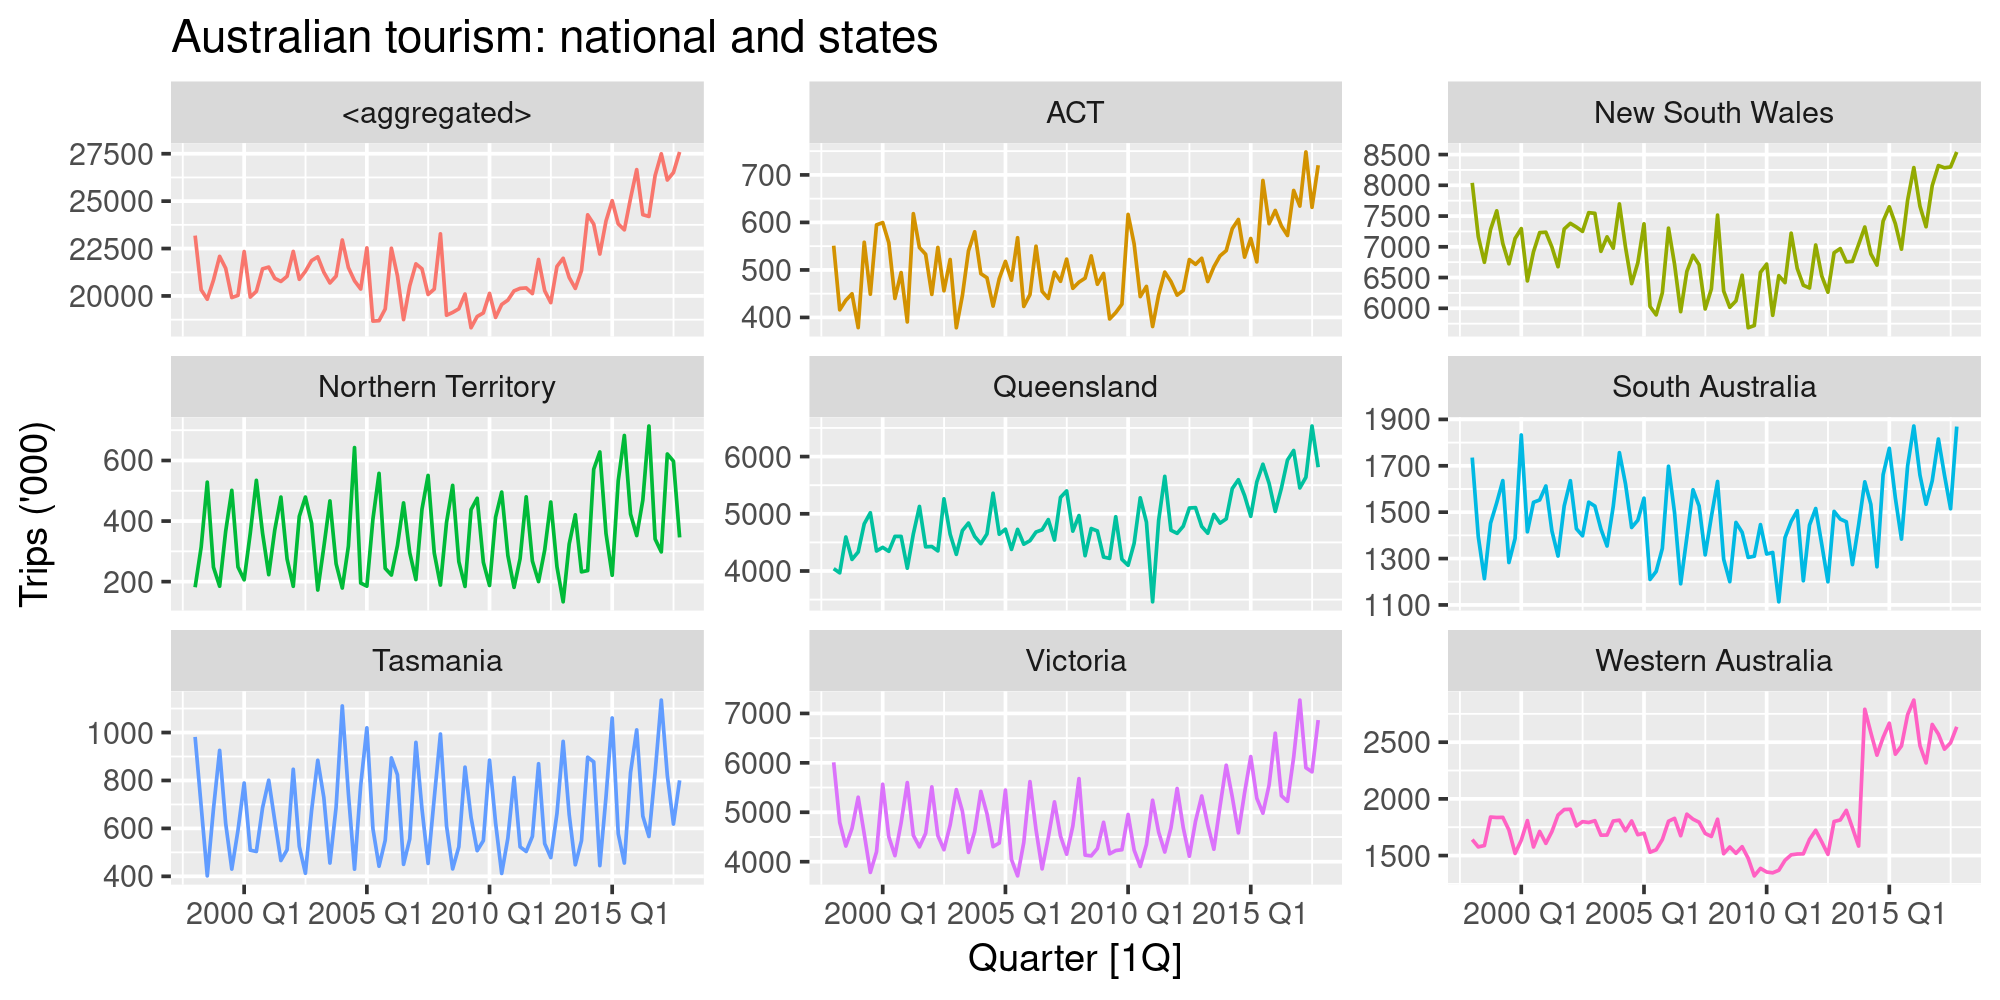

In [4]:
tourism_hts |>
  filter(is_aggregated(Region)) |>
  autoplot(Trips) +
  labs(y = "Trips ('000)", title = "Australian tourism: national and states") +
  facet_wrap(vars(State), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

## Example: Australian tourism hierarchy

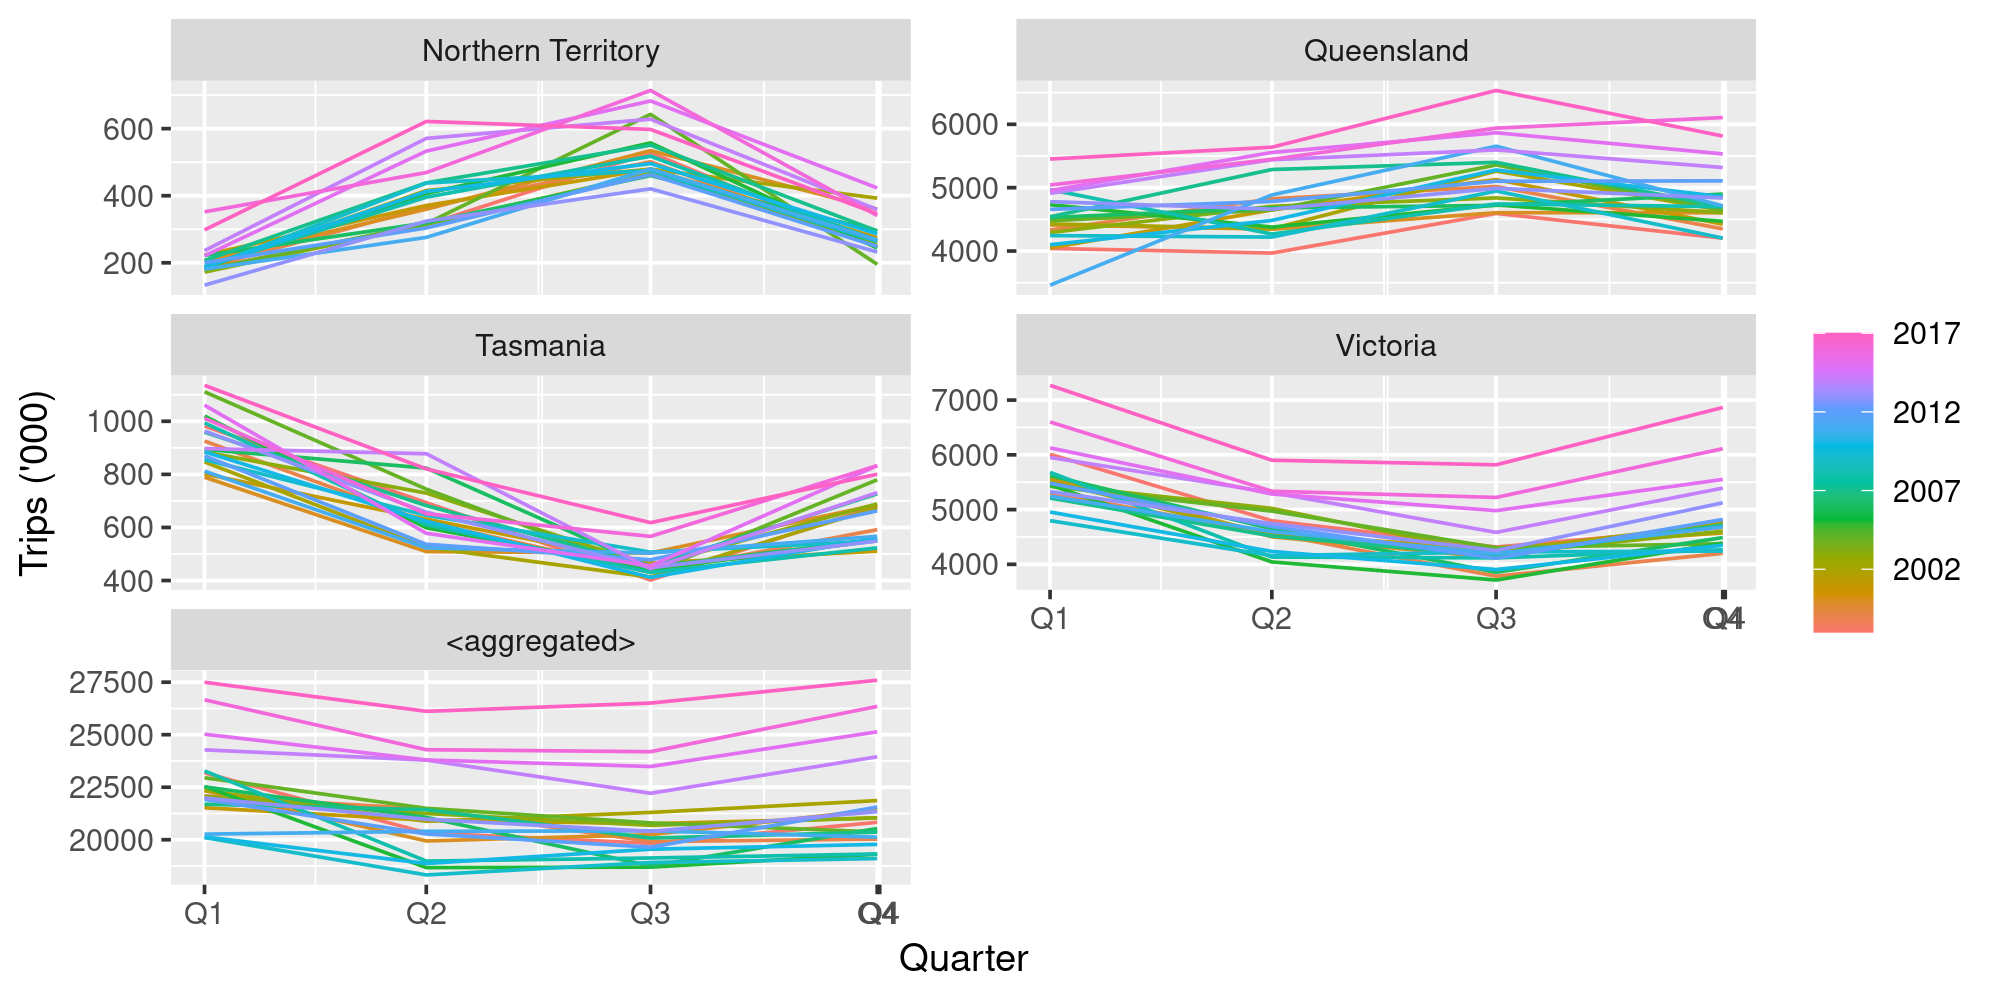

In [5]:
tourism_hts |>
  filter(State %in% c("Northern Territory", "Victoria",
                        "Queensland", "Tasmania", "<aggregated>"),
         is_aggregated(Region)) |>
  select(-Region) |>
  gg_season(Trips) +
  facet_wrap(vars(State), nrow = 3, scales = "free_y")+
  labs(y = "Trips ('000)")

## Grouped time series

With grouped time series, the data structure does not naturally disaggregate in a unique hierarchical manner.

<p align="center">
  <img src="img/GroupTree-1.png" alt="GTS" width="600"/>
</p>

This example shows that there are alternative aggregation paths for grouped structures.

For any time $t$, as with the hierarchical structure, 
\begin{equation*}
y_{t}=y_{{AX},{t}}+y_{{AY},{t}}+y_{{BX},{t}}+y_{{BY},{t}}.
\end{equation*}

 However, for the first level of the grouped structure, 
\begin{equation} y_{A,t}=y_{AX,t}+y_{AY,t}\quad \quad y_{B,t}=y_{BX,t}+y_{BY,t}
\end{equation}
but also
\begin{equation} y_{X,t}=y_{AX,t}+y_{BX,t}\quad \quad y_{Y,t}=y_{AY,t}+y_{BY,t}.
\end{equation}

## Example: Australian prison population

The four factors (state, legal status, gender, indigeneous) are crossed, but none are nested within the others.

In [6]:
prison <- readr::read_csv("https://OTexts.com/fpp3/extrafiles/prison_population.csv",
                   show_col_types = FALSE) |>
  mutate(Quarter = yearquarter(Date)) |>
  select(-Date)  |>
  as_tsibble(key = c(Gender, Legal, State, Indigenous),
             index = Quarter) |>
  relocate(Quarter)

prison

Quarter,State,Gender,Legal,Indigenous,Count
<qtr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2005 Q1,ACT,Female,Remanded,ATSI,0
2005 Q2,ACT,Female,Remanded,ATSI,1
⋮,⋮,⋮,⋮,⋮,⋮
2016 Q3,WA,Male,Sentenced,Non-ATSI,2608
2016 Q4,WA,Male,Sentenced,Non-ATSI,2625


## Example: Australian prison population

We create a grouped time series using `aggregate_key()` with attributes or groupings of interest now being crossed using the syntax `attribute1*attribute2` (in contrast to the `parent/child` syntax used for hierarchical time series). 

In [7]:
prison_gts <- prison |>
  aggregate_key(Gender * Legal * State, Count = sum(Count)/1e3)

prison_gts

Quarter,Gender,Legal,State,Count
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
2005 Q1,<aggregated>,<aggregated>,<aggregated>,24.296
2005 Q2,<aggregated>,<aggregated>,<aggregated>,24.643
⋮,⋮,⋮,⋮,⋮
2016 Q4,Male,Sentenced,VIC,4.418
2016 Q4,Male,Sentenced,WA,4.088


## Example: Australian prison population

The following code plots the total numbers of female and male prisoners across Australia.

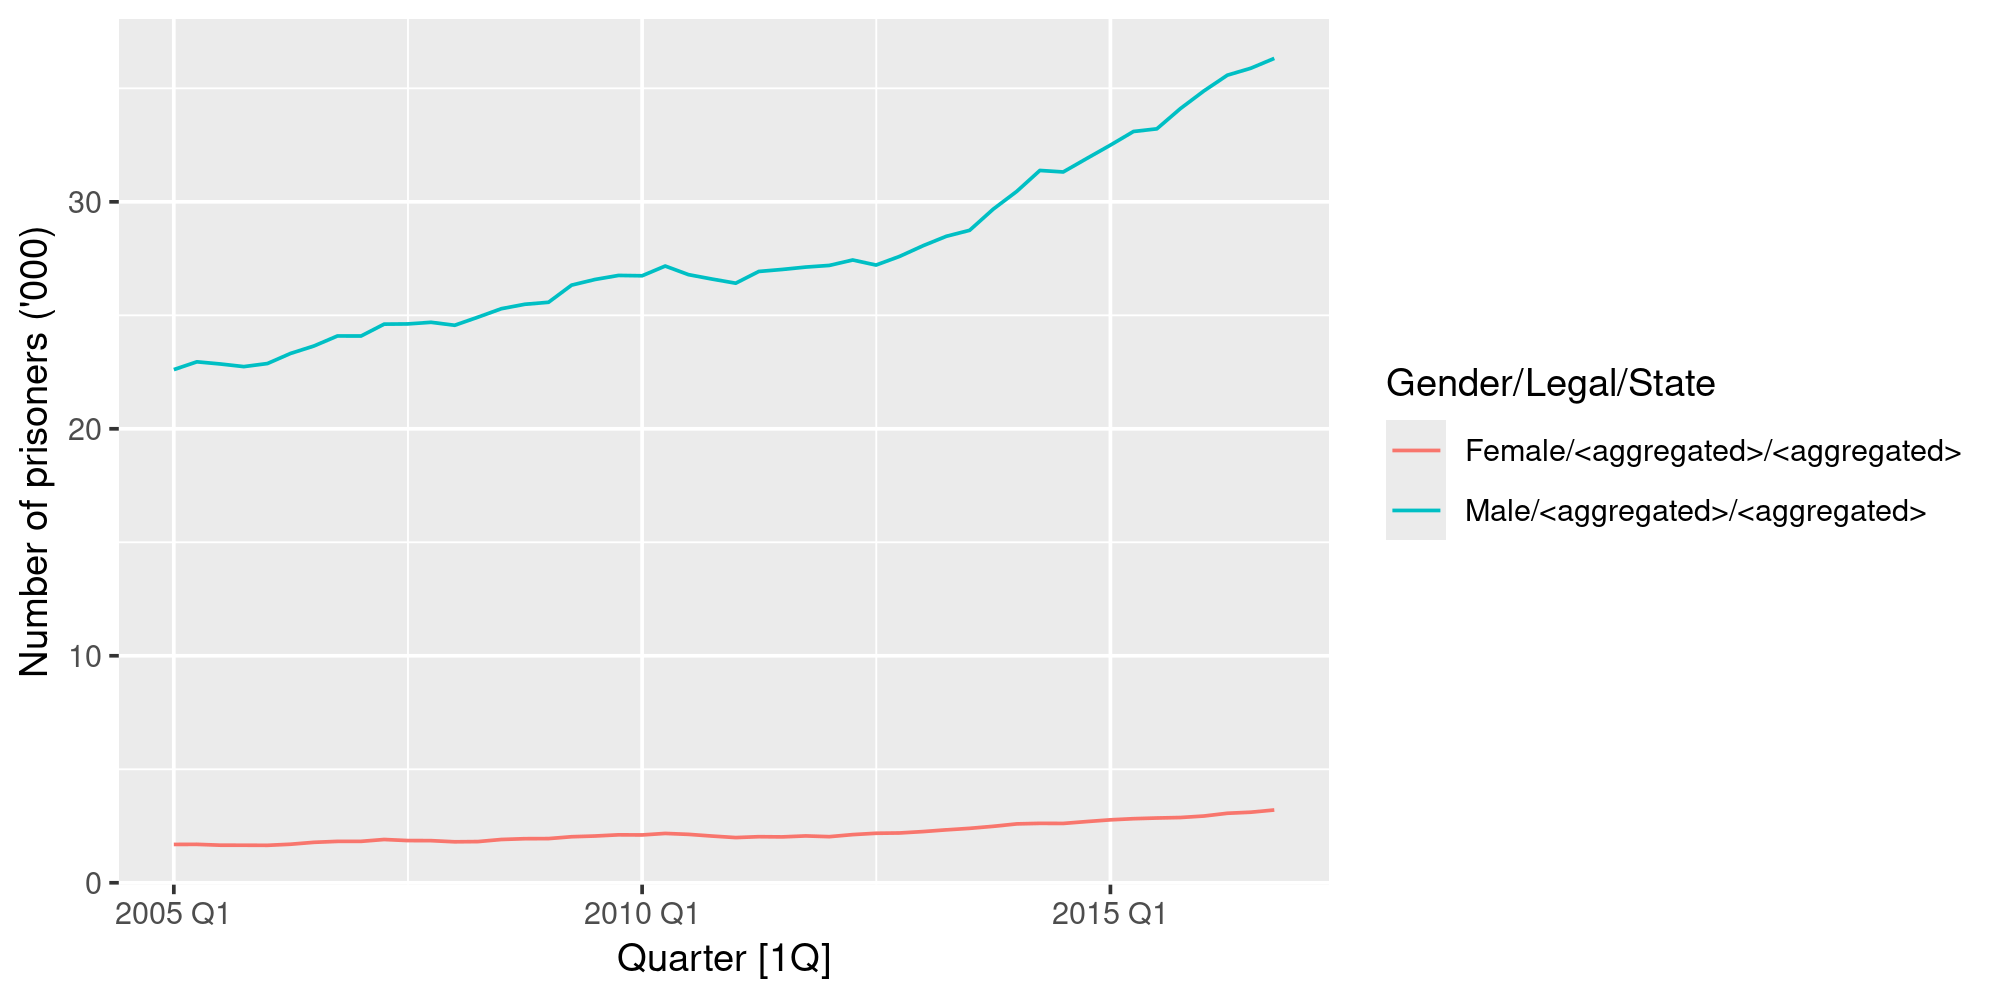

In [8]:
prison_gts |>
  filter(!is_aggregated(Gender), 
         is_aggregated(Legal),
         is_aggregated(State)) |>
  autoplot(Count) +
  labs(y = "Number of prisoners ('000)")

## Example: Australian prison population

The following code plots the total numbers of female and male prisoners across Australia.

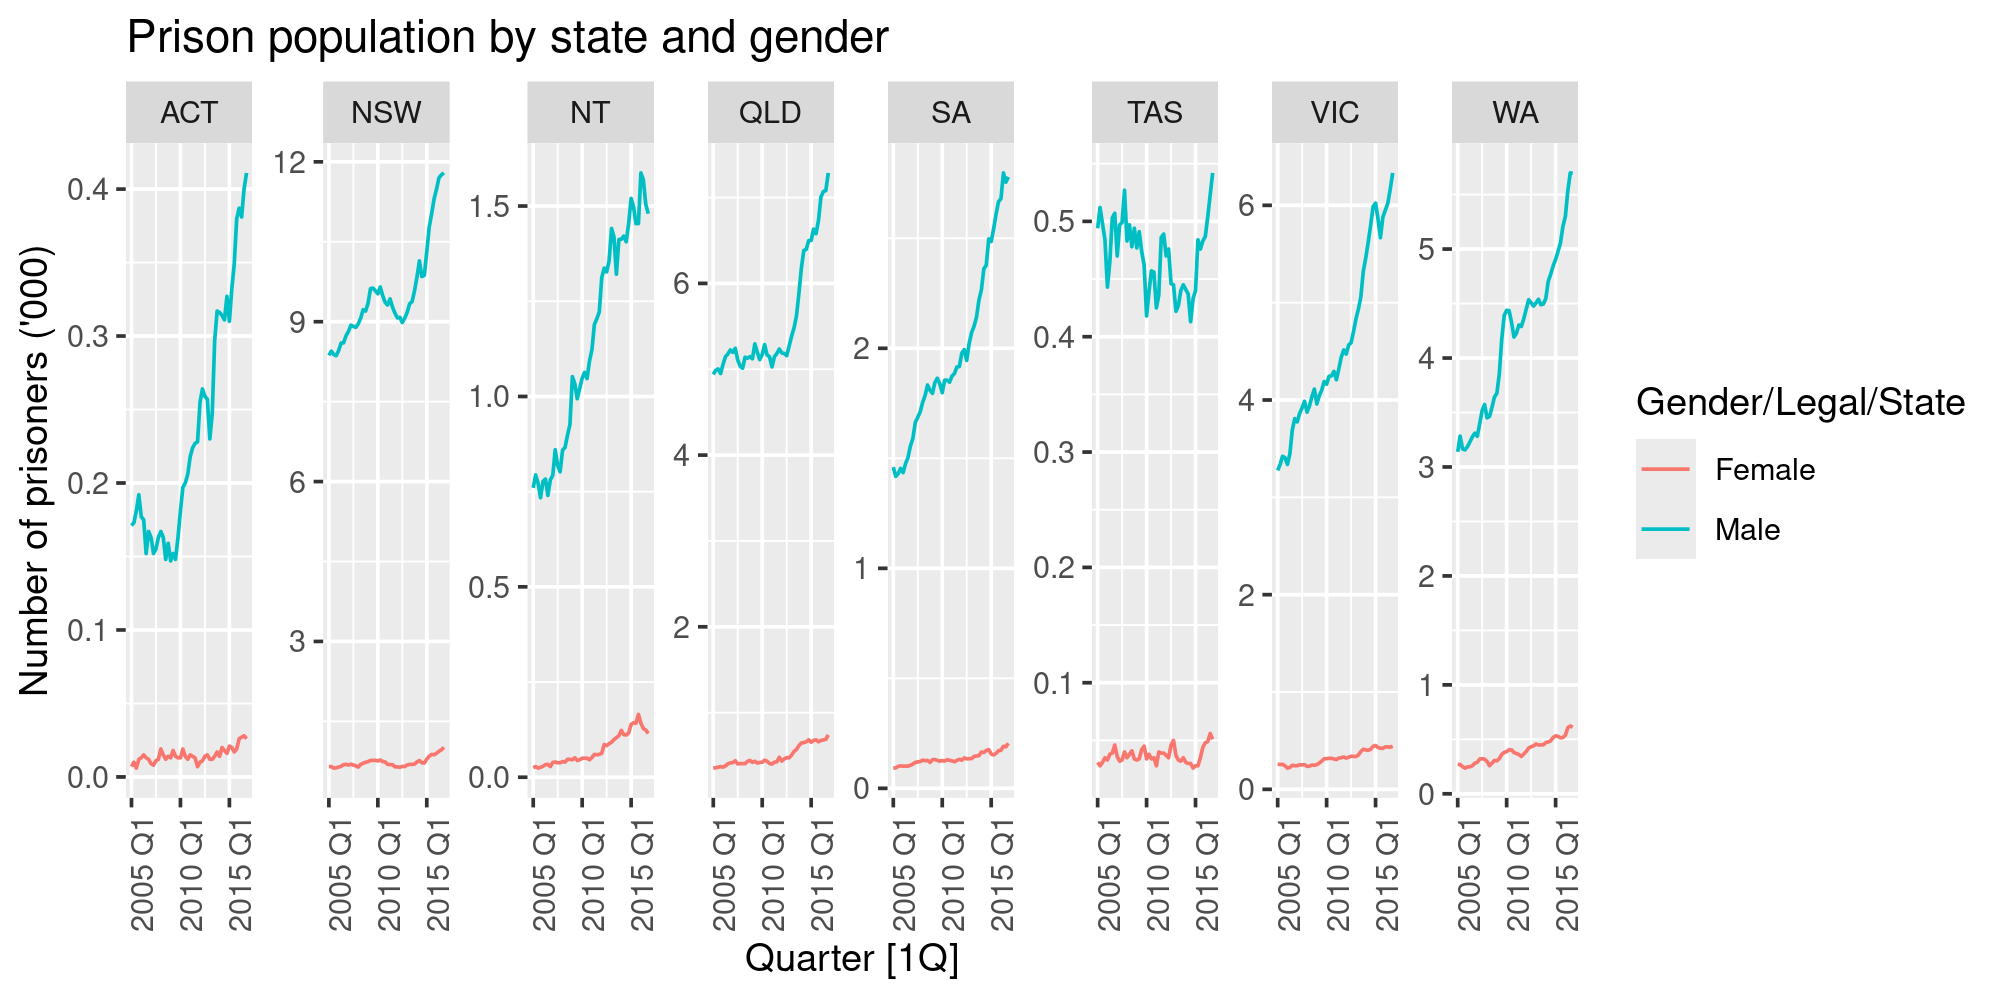

In [9]:
prison_gts |>
  filter(!is_aggregated(Gender), 
         is_aggregated(Legal),
         !is_aggregated(State)) |>
  autoplot(Count, aes(color=Gender)) +
  facet_wrap(~ as.character(State), nrow = 1, scales = "free_y") +
  labs(title = "Prison population by state and gender", y = "Number of prisoners ('000)") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Mixed hierarchical and grouped structure

Often, disaggregating factors are both nested and crossed.

For example, the Australian tourism data can also be disaggregated by the four purposes of travel. 

This grouping variable does not nest within any of the geographical variables.

We describe such a structure as a “nested” geographic hierarchy “crossed” with the purpose of travel.

In [10]:
tourism

Quarter,Region,State,Purpose,Trips
<qtr>,<chr>,<chr>,<chr>,<dbl>
1998 Q1,Adelaide,South Australia,Business,135.0777
1998 Q2,Adelaide,South Australia,Business,109.9873
⋮,⋮,⋮,⋮,⋮
2017 Q3,Yorke Peninsula,South Australia,Visiting,27.76673
2017 Q4,Yorke Peninsula,South Australia,Visiting,46.28158


## Example: Australian tourism

In [11]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

tourism_full

Quarter,State,Purpose,Region,Trips
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
1998 Q1,<aggregated>,<aggregated>,<aggregated>,23182.20
1998 Q2,<aggregated>,<aggregated>,<aggregated>,20323.38
⋮,⋮,⋮,⋮,⋮
2017 Q4,Western Australia,Other,Experience Perth,87.49492
2017 Q4,Western Australia,Visiting,Experience Perth,455.31670


## Example: Australian tourism

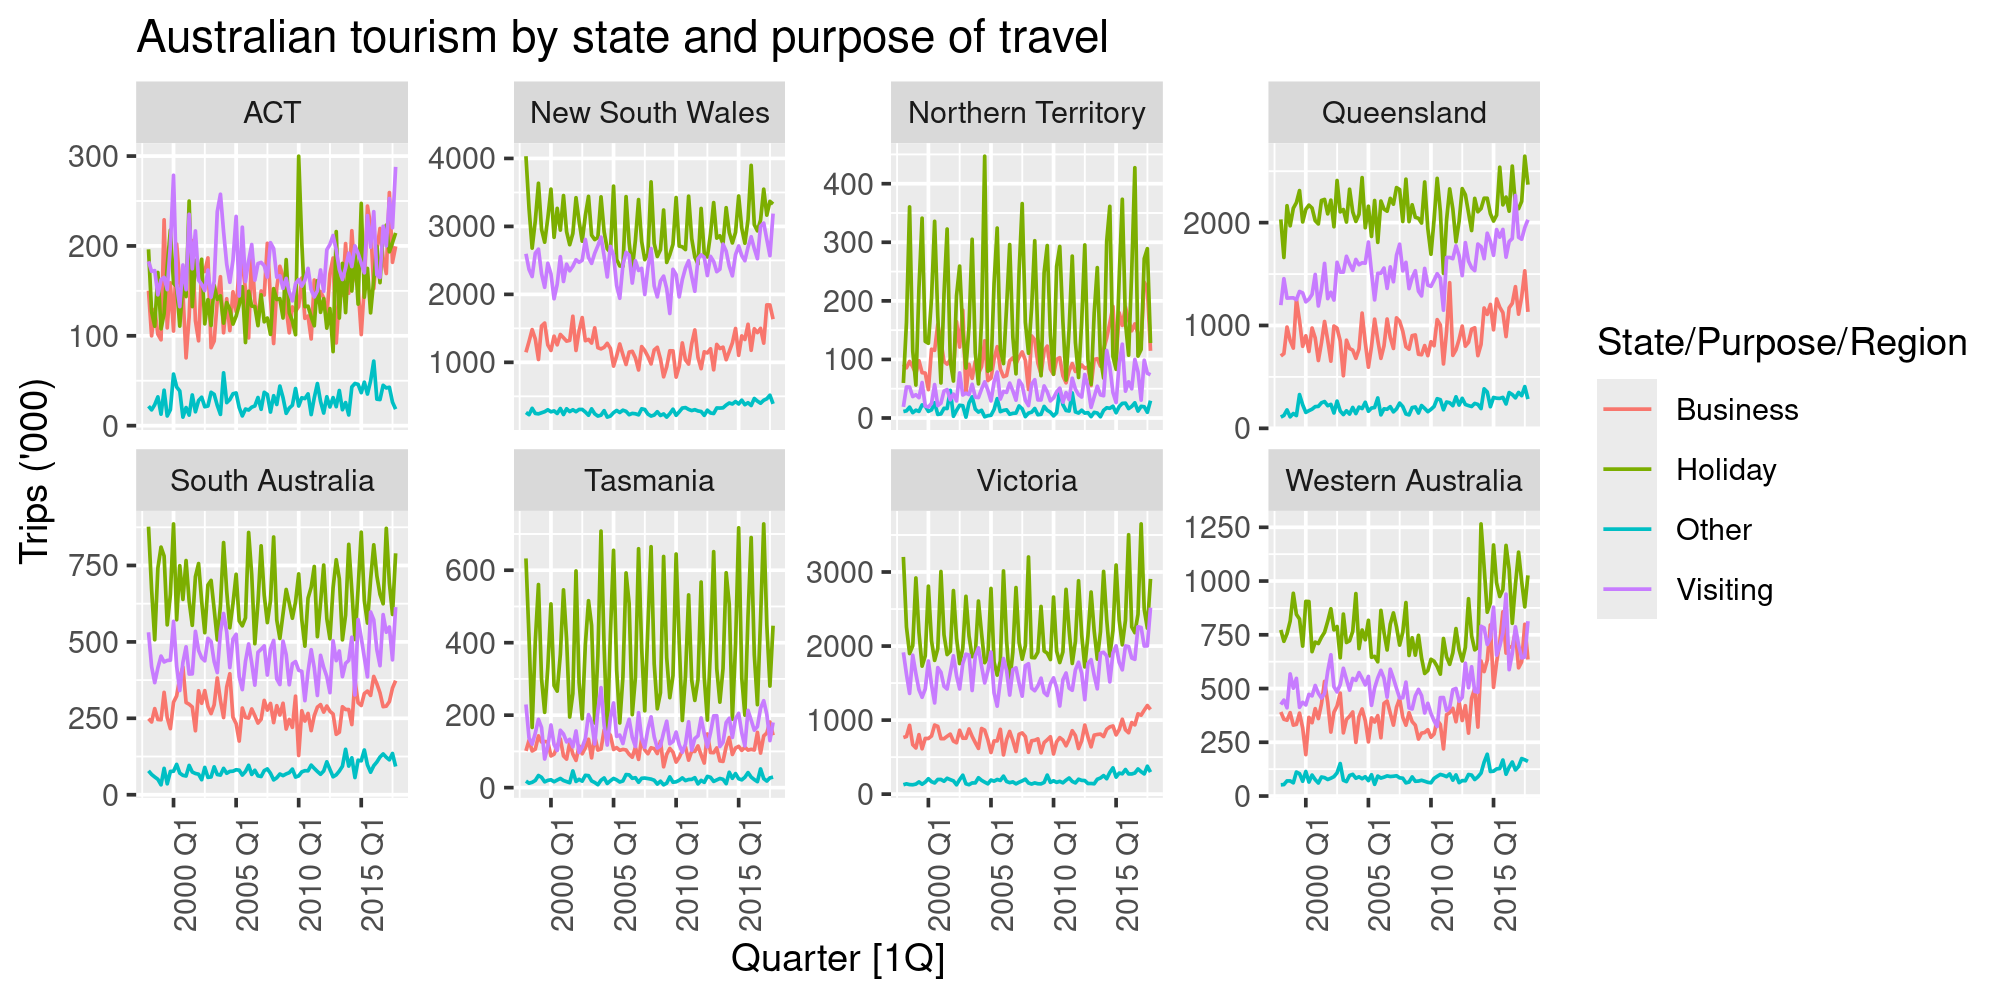

In [12]:
tourism_full |>
  filter(!is_aggregated(State),
         is_aggregated(Region),
         !is_aggregated(Purpose)) |>
  autoplot(Trips, aes(color=Purpose)) +
  facet_wrap(~ as.character(State), nrow = 2, scales = "free_y") +
  labs(title = "Australian tourism by state and purpose of travel", y = "Trips ('000)") +  
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Single level forecasting approaches

Traditionally, forecasts of hierarchical or grouped time series involved selecting one level of aggregation and generating forecasts for that level. 

These are then either aggregated for higher levels, or disaggregated for lower levels, to obtain a set of coherent forecasts for the rest of the structure.

## The bottom-up approach

A simple method for generating coherent forecasts is the “bottom-up” approach. This approach involves first generating forecasts for each series at the bottom level, and then summing these to produce forecasts for all the series in the structure.

<p align="center">
  <img src="img/hts.png" alt="HTS" width="200"/>
</p>

For example, we first generate $h$-step-ahead forecasts for each of the bottom-level series: 
$$
\hat{y}_{AA,h},~~\hat{y}_{AB,h},~~\hat{y}_{AC,h},~~ \hat{y}_{BA,h}~~\text{and}~~\hat{y}_{BB,h}.
$$
Summing these, we get $h$-step-ahead coherent forecasts for the rest of the series: 
\begin{align*}
  \tilde{y}_{h} & =\hat{y}_{AA,h}+\hat{y}_{AB,h}+\hat{y}_{AC,h}+\hat{y}_{BA,h}+\hat{y}_{BB,h}, \\
  \tilde{y}_{A,h} & = \hat{y}_{AA,h}+\hat{y}_{AB,h}+\hat{y}_{AC,h}, \\
\text{and}\quad
  \tilde{y}_{B,h} &= \hat{y}_{BA,h}+\hat{y}_{BB,h}.
\end{align*}

An advantage of this approach is that we are forecasting at the bottom level of a structure, and therefore no information is lost due to aggregation. On the other hand, bottom-level data can be quite noisy and more challenging to model and forecast.

## Example: Generating bottom-up forecasts

Suppose we want national and state forecasts for the Australian tourism data, but we aren’t interested in disaggregations using regions or the purpose of travel.

So we first create a simple `tsibble` object containing only state and national trip totals for each quarter.

In [13]:
tourism_states <- tourism |>
  aggregate_key(State, Trips = sum(Trips))

We could generate the bottom-level state forecasts first, and then sum them to obtain the national forecasts.

In [14]:
fcasts_state <- tourism_states |>
  filter(!is_aggregated(State)) |>
  model(ets = ETS(Trips)) |>
  forecast()

# Sum bottom-level forecasts to get top-level forecasts
fcasts_national <- fcasts_state |>
  summarise(value = sum(Trips), .mean = mean(value))

## Example: Generating coherent bottom-up forecasts

However, we want a more general approach that will work with all the forecasting methods discussed in this chapter. So we will use the `reconcile()` function to specify how we want to compute coherent forecasts.

In [15]:
fcasts_national <- tourism_states |>
  model(ets = ETS(Trips)) |>
  reconcile(bu = bottom_up(ets)) |>
  forecast()

fcasts_national

State,.model,Quarter,Trips,.mean
<chr*>,<chr>,<qtr>,<dist>,<dbl>
ACT,ets,2018 Q1,"N(701, 7651)",700.6943
ACT,ets,2018 Q2,"N(717, 8032)",717.2949
⋮,⋮,⋮,⋮,⋮
<aggregated>,bu,2019 Q3,"N(26333, 920929)",26333.13
<aggregated>,bu,2019 Q4,"N(27232, 1092272)",27231.95


The `reconcile()` step has created a new “model” to produce bottom-up forecasts. 

The `fable` object contains the `ets` forecasts as well as the coherent `bu` forecasts, for the 8 states and the national aggregate. At the state level, these forecasts are identical, but the national `ets` forecasts will be different from the national `bu forecasts`.

For bottom-up forecasting, this is rather inefficient as we are not interested in the ETS model for the national total. But later we will introduce more advanced methods where we will need models for all levels of aggregation.

## Workflow for forecasting aggregation structures

```
data |> 
    aggregate_key() |> 
    model() |>
    reconcile() |> 
    forecast()
```

1. Begin with a `tsibble` object (here labelled data) containing the individual bottom-level series.
2. Define in `aggregate_key()` the aggregation structure and build a tsibble object that also contains the aggregate series.
3. Identify a `model()` for each series, at all levels of aggregation.
4. Specify in `reconcile()` how the coherent forecasts are to be generated from the selected models.
5. Use the `forecast()` function to generate forecasts for the whole aggregation structure.


## Top-down forecasting approaches

Top-down approaches involve first generating forecasts for the Total series $y_t$, and then disaggregating these down the hierarchy.

<p align="center">
  <img src="img/hts.png" alt="HTS" width="200"/>
</p>

Let $p_1,\ldots,p_m$ denote a set of disaggregation proportions which determine how the forecasts of the Total series are to be distributed to obtain forecasts for each series at the bottom level of the structure. 
$$
\tilde{y}_{AA,t}=p_1\hat{y}_t,\quad 
\tilde{y}_{AB,t}=p_2\hat{y}_t,\quad 
\tilde{y}_{AC,t}=p_3\hat{y}_t,\quad 
\tilde{y}_{BA,t}=p_4\hat{y}_t \quad 
\text{and}\quad 
\tilde{y}_{BB,t}=p_5\hat{y}_t.
$$

Once the bottom-level $h$-step-ahead forecasts have been generated, these are aggregated to generate coherent forecasts for the rest of the series.

Top-down forecasts can be generated using `top_down()` within the `reconcile()` function.

There are several possible top-down methods that can be specified. The two most common top-down approaches specify disaggregation proportions based on the historical proportions of the data. 

## Average historical proportions

$$
p_j=\frac{1}{T}\sum_{t=1}^{T}\frac{y_{j,t}}{{y_t}}
$$

This approach is implemented in the `top_down()` function by setting `method = "average_proportions"`.

## Proportions of the historical averages

$$
p_j={\sum_{t=1}^{T}\frac{y_{j,t}}{T}}\Big/{\sum_{t=1}^{T}\frac{y_t}{T}}
$$

This approach is implemented in the `top_down()` function by setting `method = "proportion_averages"`.

## Forecast proportions

Because historical proportions used for disaggregation do not take account of how those proportions may change over time, top-down approaches based on historical proportions tend to produce less accurate forecasts at lower levels of the hierarchy than bottom-up approaches. 

To address this issue, proportions based on forecasts rather than historical data can be used.

This approach is implemented in the `top_down()` function by setting `method = "forecast_proportions"`. 

Because this approach tends to work better than other top-down methods, it is the default choice in the `top_down()` function when no method argument is specified.

## Pros and cons of top-down approaches

A convenient attribute of such top-down approaches is their simplicity. One only needs to model and generate forecasts for the most aggregated top-level series. 

In general, these approaches seem to produce quite reliable forecasts for the aggregate levels and they are useful with low count data. 

On the other hand, one disadvantage is the loss of information due to aggregation. Using such top-down approaches, we are unable to capture and take advantage of individual series characteristics such as time dynamics, special events, different seasonal patterns, etc.

## Middle-out approach

The middle-out approach combines bottom-up and top-down approaches. Again, it can only be used for strictly hierarchical aggregation structures.

First, a “middle” level is chosen and forecasts are generated for all the series at this level. For the series above the middle level, coherent forecasts are generated using the bottom-up approach by aggregating the “middle-level” forecasts upwards. For the series below the “middle level”, coherent forecasts are generated using a top-down approach by disaggregating the “middle level” forecasts downwards.

This approach is implemented in the `middle_out()` function by specifying the appropriate middle level via the level argument and selecting the top-down approach with the method argument.

## Modern forecast reconciliation methods

The traditional methods considered so far are limited in that they only use base forecasts from a single level of aggregation which have either been aggregated or disaggregated to obtain forecasts at all other levels. 
Hence, they use limited information. 

"Optimal" reconciliation approaches try to use all the information available within a hierarchical or a grouped structure.

This is important, as particular aggregation levels or groupings may reveal features of the data that are of interest to the user and are important to be modelled. 

These features may be completely hidden or not easily identifiable at other levels.

Two popular approaches that try to minimize variance of forecasts:

- `min_trace(base, method = "ols")`
- `min_trace(base, method = "mint_shrink")`
    

## Forecasting Australian domestic tourism

In [16]:
tourism_full <- tourism |>
  aggregate_key((State/Region) * Purpose, Trips = sum(Trips))

tourism_full

Quarter,State,Purpose,Region,Trips
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
1998 Q1,<aggregated>,<aggregated>,<aggregated>,23182.20
1998 Q2,<aggregated>,<aggregated>,<aggregated>,20323.38
⋮,⋮,⋮,⋮,⋮
2017 Q4,Western Australia,Other,Experience Perth,87.49492
2017 Q4,Western Australia,Visiting,Experience Perth,455.31670


## Forecasting Australian domestic tourism

We use the data up to the end of 2015 as a training set, withholding the final two years (eight quarters, 2016 Q1 – 2017 Q4) as a test set for evaluation. 

In [17]:
fit <- tourism_full |>
  filter(year(Quarter) <= 2015) |>
  model(base = ETS(Trips)) |>
  reconcile(
    bu = bottom_up(base),
    ols = min_trace(base, method = "ols")
  )

In [18]:
fc <- fit |> forecast(h = "2 years")

## Forecasting Australian domestic tourism

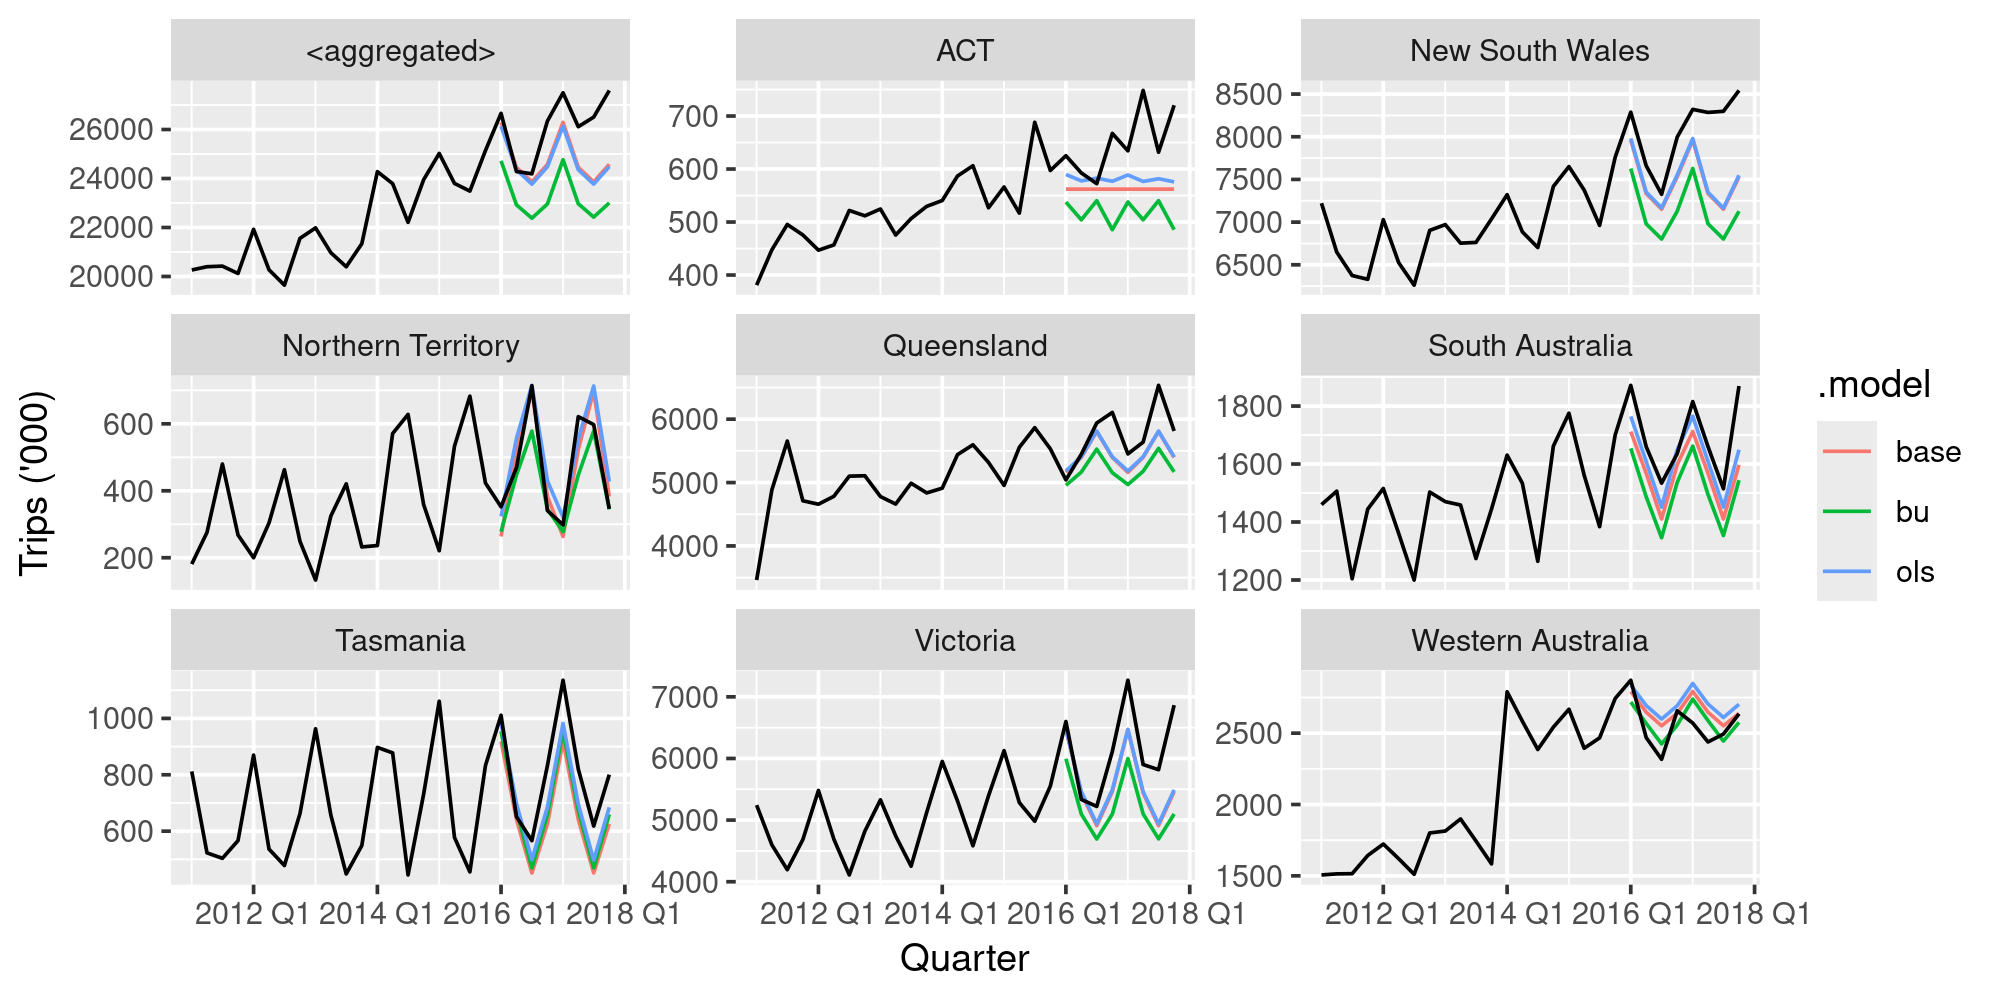

In [19]:
fc |>
  filter(is_aggregated(Region), is_aggregated(Purpose)) |>
  autoplot(
    tourism_full |> filter(year(Quarter) >= 2011),
    level = NULL
  ) +
  labs(y = "Trips ('000)") +
  facet_wrap(vars(State), scales = "free_y")

## Forecasting Australian domestic tourism

In [20]:
fc |>
  filter(is_aggregated(State)) |>
  accuracy(
    data = tourism_full,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

.model,rmse,mase
<chr>,<dbl>,<dbl>
base,770.5586,1.370175
bu,1256.3626,2.492375
ols,771.2485,1.326065


## Forecasting Australian prison population

In [21]:
prison_gts <- prison |>
  aggregate_key(Gender * Legal * State, Count = sum(Count)/1e3)

prison_gts

Quarter,Gender,Legal,State,Count
<qtr>,<chr*>,<chr*>,<chr*>,<dbl>
2005 Q1,<aggregated>,<aggregated>,<aggregated>,24.296
2005 Q2,<aggregated>,<aggregated>,<aggregated>,24.643
⋮,⋮,⋮,⋮,⋮
2016 Q4,Male,Sentenced,VIC,4.418
2016 Q4,Male,Sentenced,WA,4.088


In [22]:
fit <- prison_gts |>
  filter(year(Quarter) <= 2014) |>
  model(base = ETS(Count)) |>
  reconcile(
    bottom_up = bottom_up(base),
    MinT = min_trace(base, method = "mint_shrink")
  )
fc <- fit |> forecast(h = 8)

## Forecasting Australian prison population

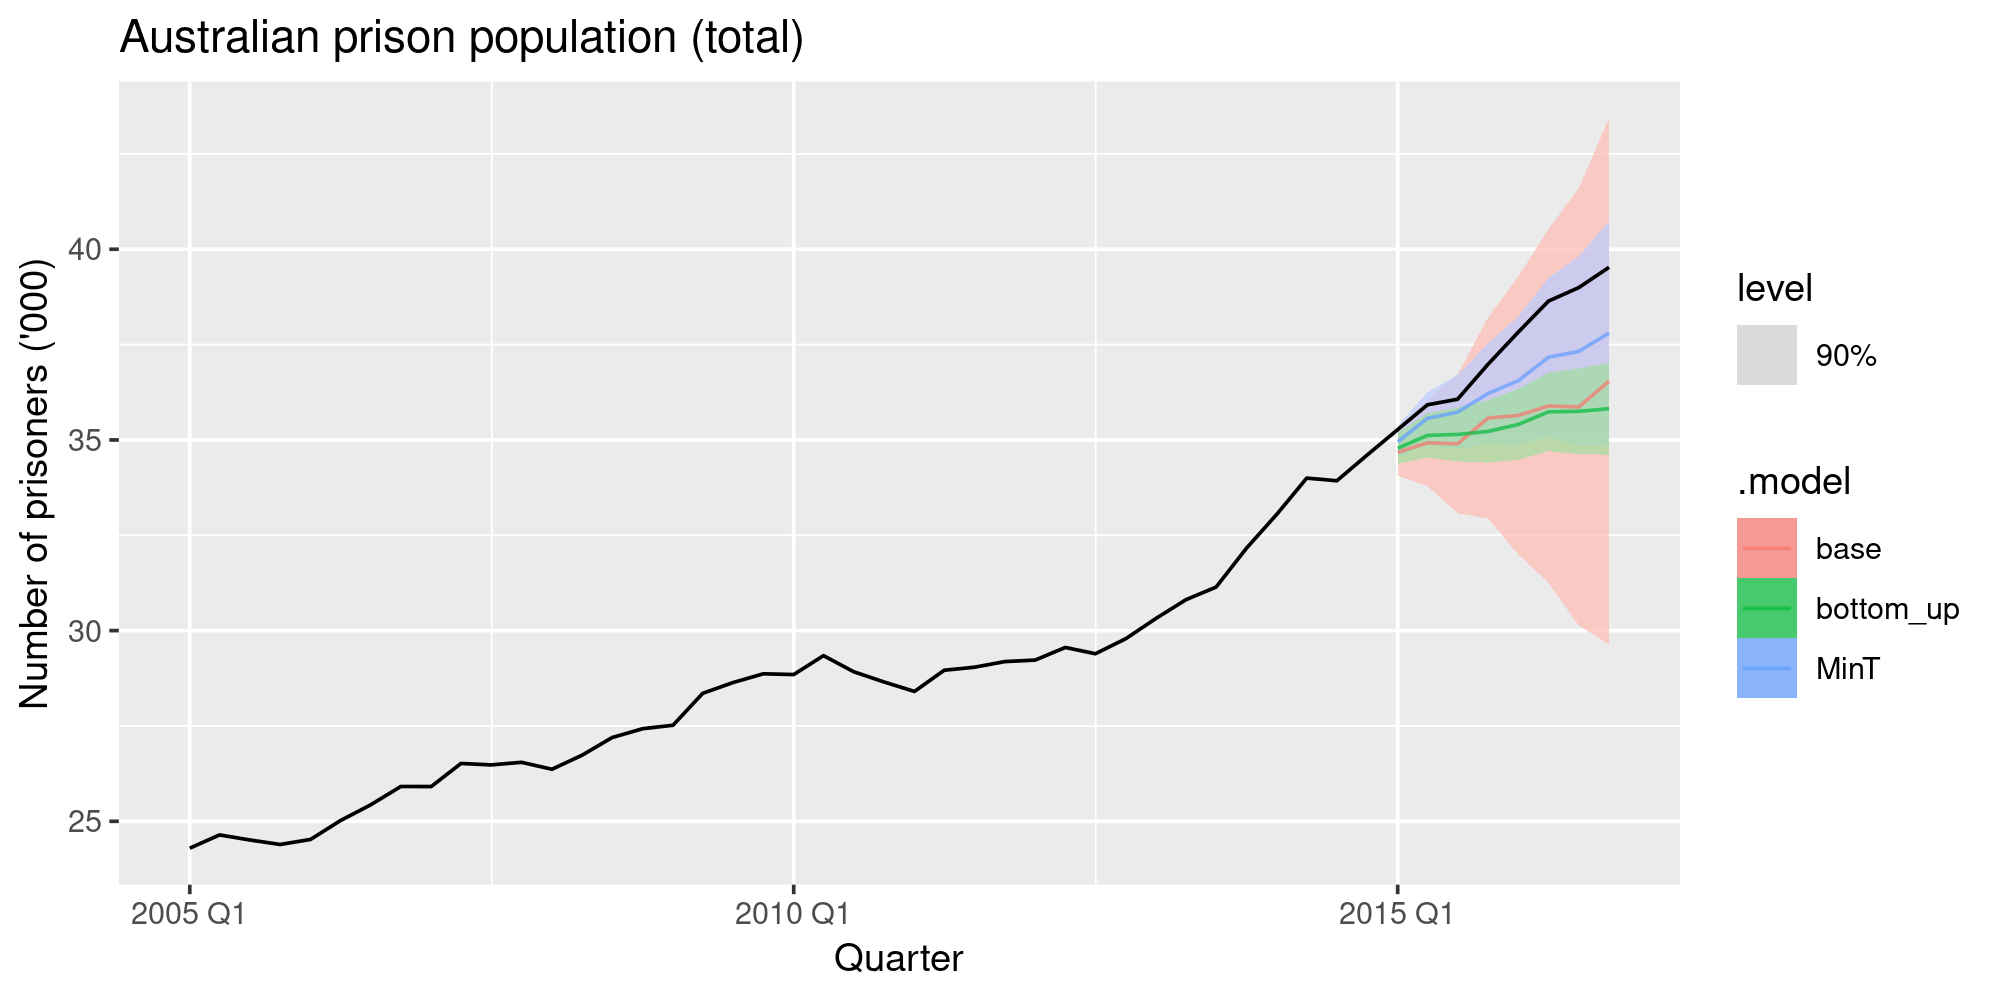

In [23]:
fc |>
  filter(is_aggregated(State), 
         is_aggregated(Gender),
         is_aggregated(Legal)) |>
  autoplot(prison_gts, alpha = 0.7, level = 90) +
  labs(y = "Number of prisoners ('000)", title = "Australian prison population (total)")

The base and bottom-up forecasts from the ETS models seem to underestimate the trend over the test period. 

The MinT approach combines information from all the base forecasts in the aggregation structure; in this case, the base forecasts at the top level are adjusted upwards.

The MinT reconciled prediction intervals are much tighter than the base forecasts, due to MinT being based on an estimator that minimizes variances. 

In [24]:
fc |>
  filter(is_aggregated(State), is_aggregated(Gender), is_aggregated(Legal)) |>
  accuracy(
    data = prison_gts,
    measures = list(rmse = RMSE, mase = MASE)
  ) |>
  group_by(.model) |>
  summarise(rmse = mean(rmse), mase = mean(mase))

.model,rmse,mase
<chr>,<dbl>,<dbl>
MinT,1.145009,0.8951647
base,2.113924,1.7198775
bottom_up,2.329145,1.8362024


The results show that the MinT reconciled forecasts improve on the accuracy of the base forecasts and are also more accurate than the bottom-up forecasts. 

## Forecasting Australian prison population

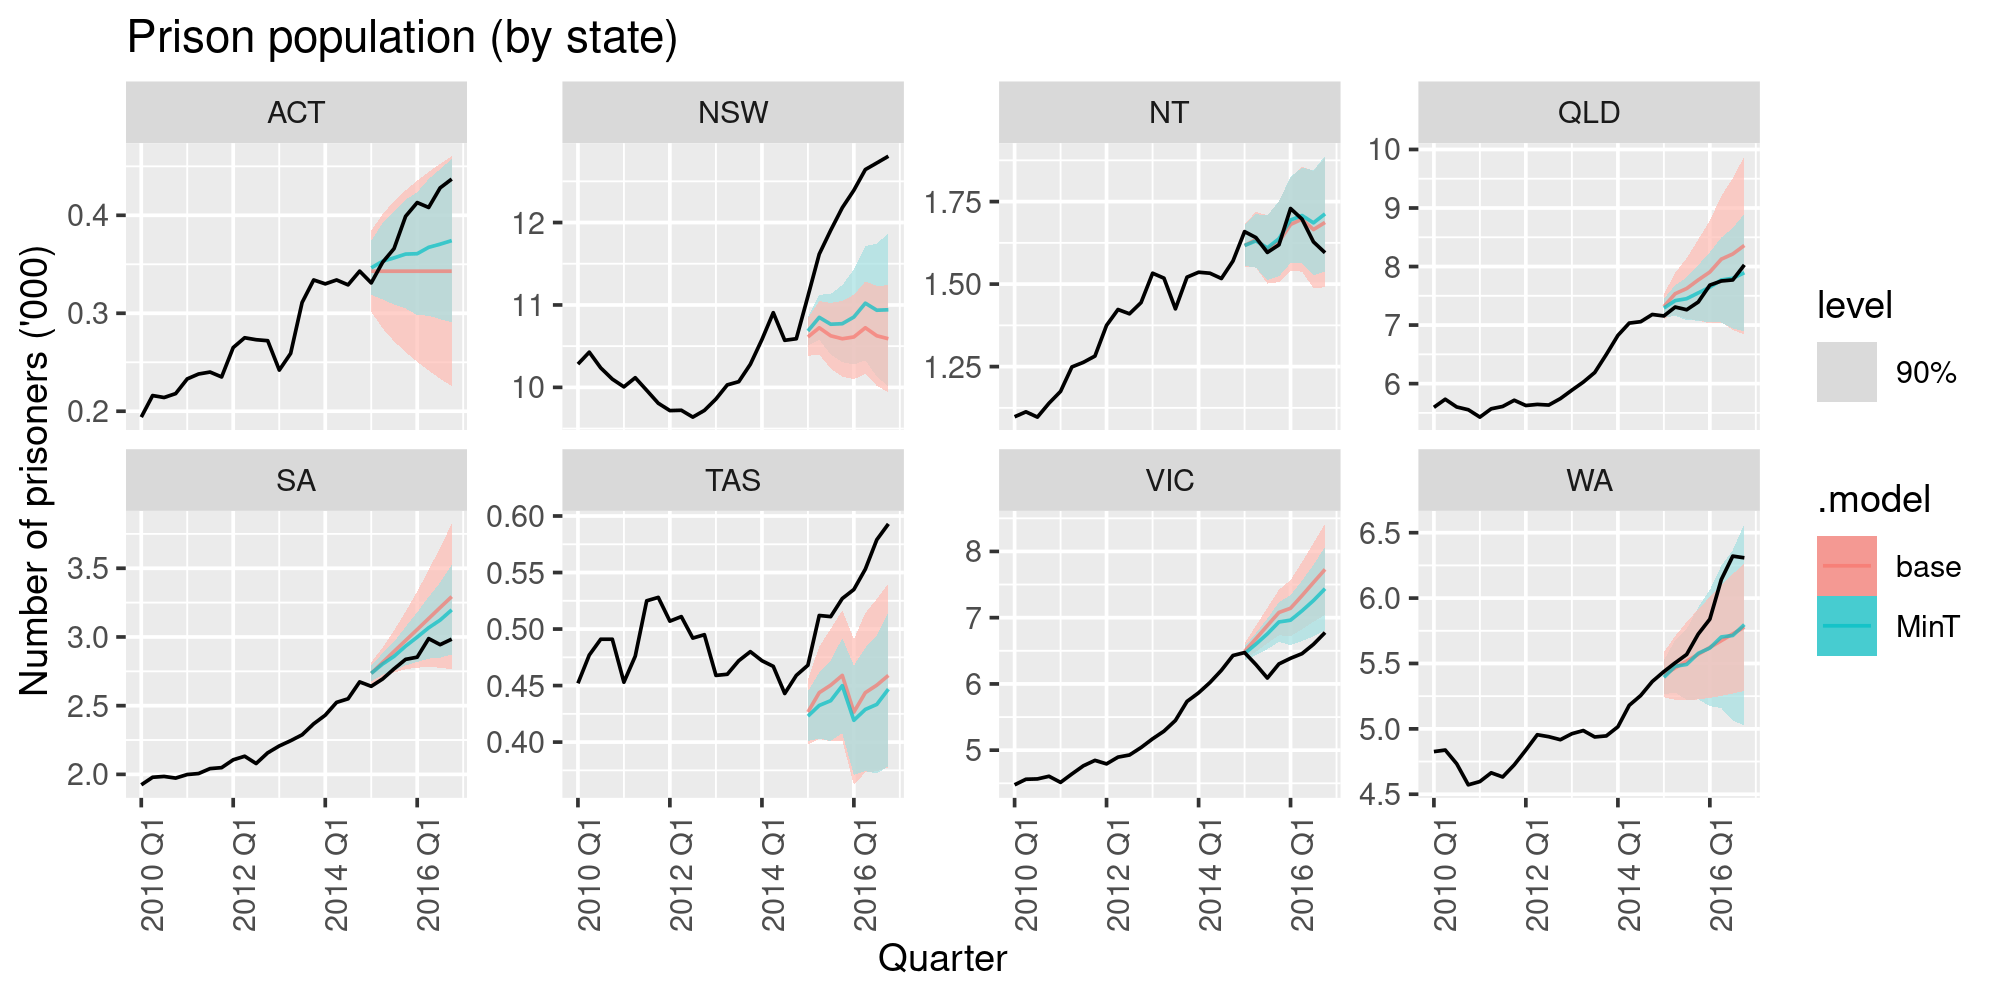

In [25]:
fc |>
  filter(.model %in% c("base", "MinT"),
         !is_aggregated(State), is_aggregated(Legal), is_aggregated(Gender)
        ) |>
  autoplot(prison_gts |> filter(year(Quarter) >= 2010), alpha = 0.7, level = 90) +
  labs(title = "Prison population (by state)", y = "Number of prisoners ('000)") +
  facet_wrap(vars(State), scales = "free_y", ncol = 4) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Forecasting Australian prison population

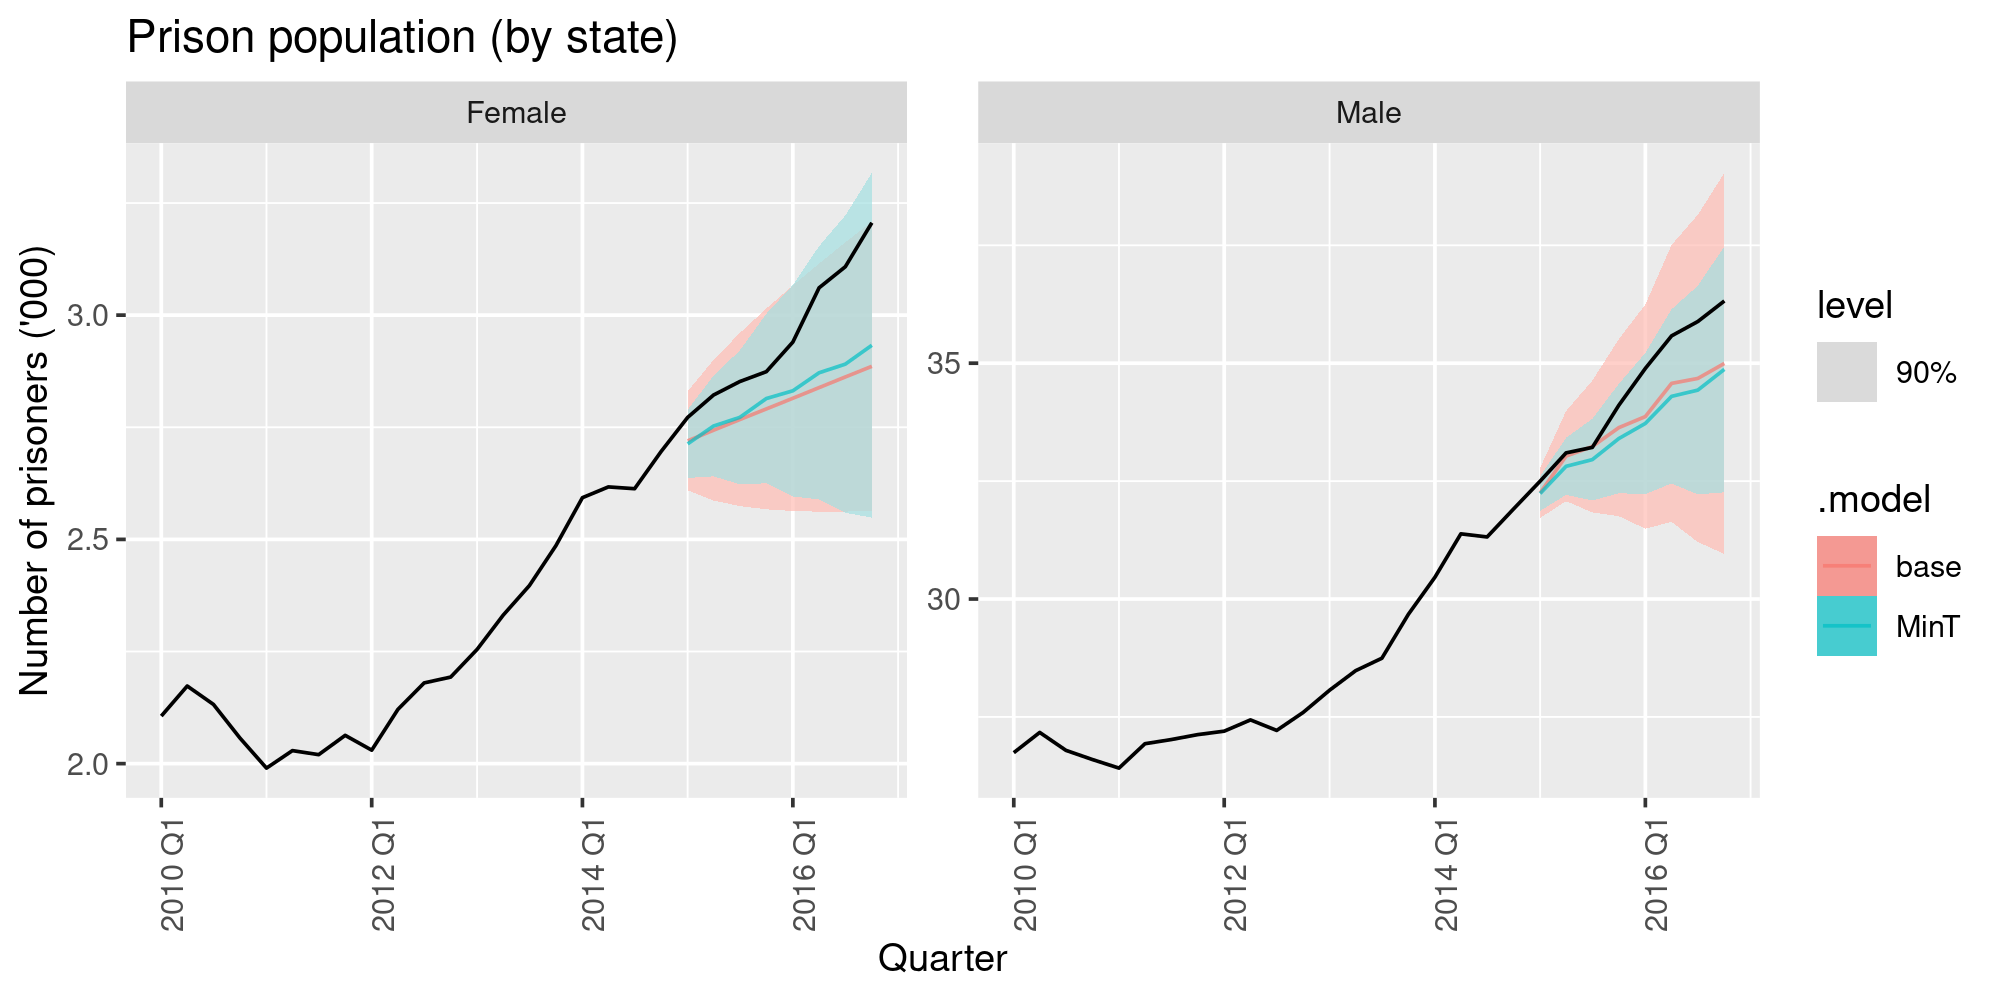

In [26]:
fc |>
  filter(.model %in% c("base", "MinT"),
         is_aggregated(State), is_aggregated(Legal), !is_aggregated(Gender)
        ) |>
  autoplot(prison_gts |> filter(year(Quarter) >= 2010), alpha = 0.7, level = 90) +
  labs(title = "Prison population (by state)", y = "Number of prisoners ('000)") +
  facet_wrap(vars(Gender), scales = "free_y", ncol = 4) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Forecasting Australian prison population

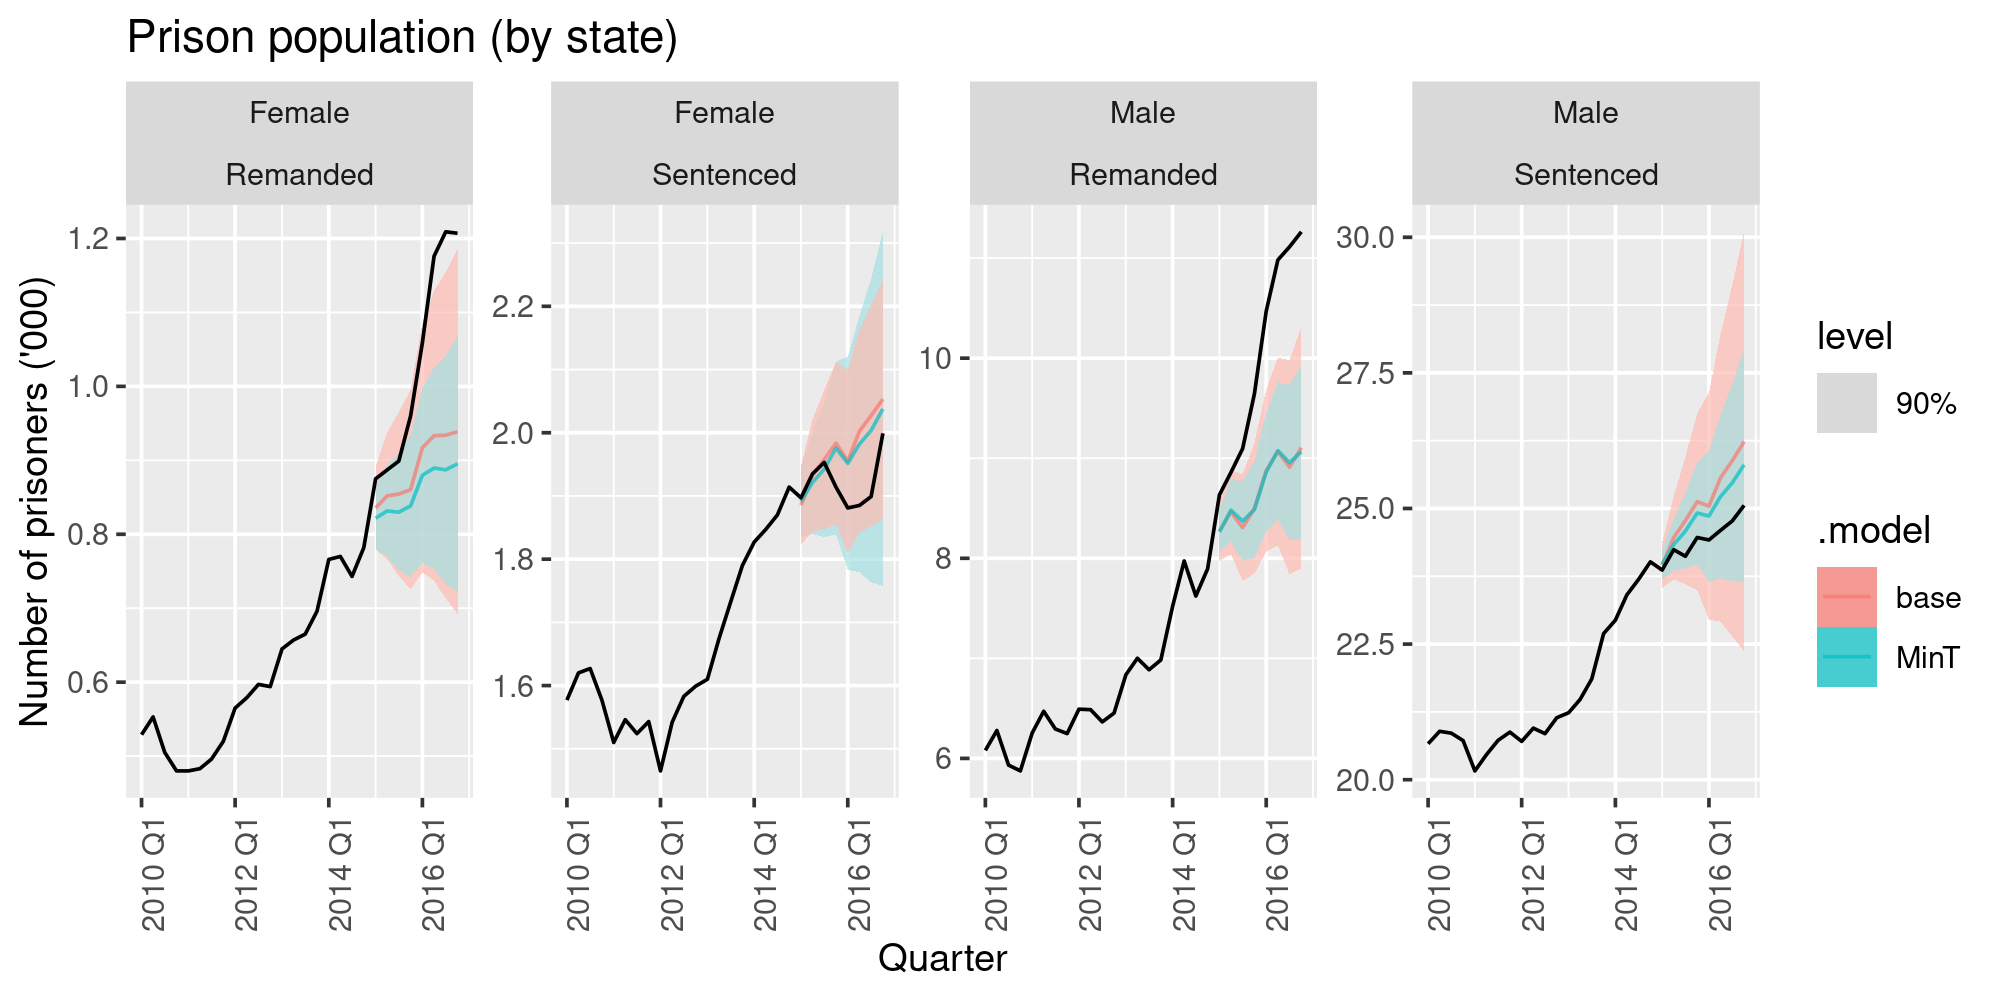

In [27]:
fc |>
  filter(.model %in% c("base", "MinT"),
         is_aggregated(State), !is_aggregated(Legal), !is_aggregated(Gender)
        ) |>
  autoplot(prison_gts |> filter(year(Quarter) >= 2010), alpha = 0.7, level = 90) +
  labs(title = "Prison population (by state)", y = "Number of prisoners ('000)") +
  facet_wrap(vars(Gender,Legal), scales = "free_y", ncol = 4) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Next time

- Advanced forecasting methods